# FLux.jl MNIST example

Training a Convolutional Neural Network (CNN) against the famous MNIST dataset of handwritten digits. Much of the credit for this notebook should go to this [blog](https://www.freecodecamp.org/news/deep-learning-with-julia/) and its code published on [github](https://github.com/AndreyGermanov/phones_reader).

In [1]:
# Packages
using Pkg
Pkg.activate(".")
#Pkg.instantiate()
using Images
using Flux
using ZipFile
using BSON
using Plots, Measures
using JLD

  Activating project at `~/src_nobackup/julia_ml_tests.jl.git`


In [3]:
# mnist images from [this archive](https://www.kaggle.com/datasets/jidhumohan/mnist-png)
# we have a copy in the data directory
data_root = "data"
zip_file = "archive.zip"

function mkdir_p(path) # make directory and parents if needed
    if !isdir(path)
        # check for parent directory
        if !(path=="/" || path=="")
            parentDir = dirname(path)
            if !isdir(parentDir)
                mkdir_p(parentDir)
            end
        end
        mkdir(path)
    end
end

if !isdir(joinpath(data_root,"mnist_png"))
    zarchive = ZipFile.Reader(joinpath(data_root,zip_file))
    for f in zarchive.files
        if contains(f.name,"mnist_png/mnist_png") # the has two copies of the data
            continue
        end
        println(f.name)
        fullFilePath = joinpath(data_root,f.name)
        if endswith(f.name,"/")
            println("creating directory: ",fullFilePath)
            mkdir_p(fullFilePath)
        else
            println("creating file: ",fullFilePath)
            # check for parent directory
            parentDir = dirname(fullFilePath)
            if !isdir(parentDir)
                println("creating directory: ",parentDir)
                mkdir_p(parentDir)
            end
            out =  open(fullFilePath,"w")
            write(out,read(f,String))
            close(out) 
        end
    end
    close(zarchive)
end

# paths with images and labels
training_images_path = joinpath(data_root,"mnist_png","training")
testing_images_path = joinpath(data_root,"mnist_png","testing")

nothing

In [22]:

# Function that loads images from files and returns a dataset
function createDataset(path,number_of_images)
    X = zeros(Float32,28,28,1,number_of_images) # 28x28x1 is the size of the images, one channel
    y = zeros(Float32,number_of_images)
    icount = 0
    for label in readdir(path)
        println("Loading label $(label) from path $(path)")
        for file in readdir(joinpath(path,label))
            icount += 1
            if icount%1000 == 0
                println("$(icount): Loading file $(file) from path $(path)/$(label)")
            end
            img = load(joinpath(path,label,file))
            data = reshape(Float32.(channelview(img)),28,28,1)
            X[:,:,1,icount] = data
            y[icount]= parse(Float32,label)
        end
    end
    return X,y
end;

# Load the dataset
if !isfile("data/mnist.jld")
    x_train,y_train = createDataset(training_images_path,60000);
    x_test,y_test = createDataset(testing_images_path,10000);
    @save "data/mnist.jld" x_train y_train x_test y_test
else
    @load "data/mnist.jld" x_train y_train x_test y_test
end

4-element Vector{Symbol}:
 :x_train
 :y_train
 :x_test
 :y_test

In [23]:
# Limit the size of the training set
# Note that training set is not shuffled. It has eg all the zeros at the start
n_train = 5000
idx = rand(1:size(x_train,4),n_train)
x_train = x_train[:,:,:,idx]
y_train = y_train[idx]
nothing

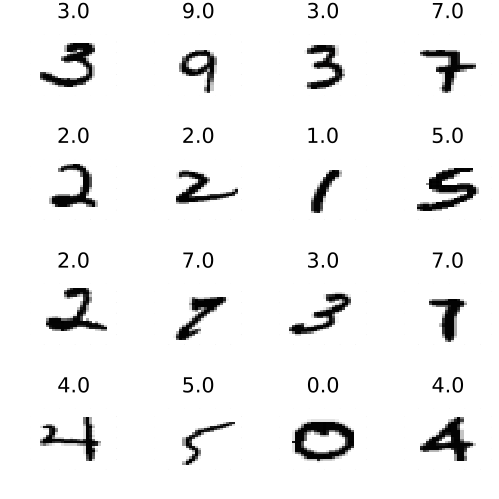

In [24]:
size(x_train),size(y_train),size(x_test),size(y_test)
n_train,n_test = size(x_train)[end],size(x_test)[end]
# show a few images
#heatmap(1f0.-x_train[:,:,1,1],size=(100,100),legend=false,showaxis=false,color=:greys,margin=0mm,title="$(y_train[1])")
plot_array = []
for i = 1:4, j = 1:4
    i_rand = rand(1:n_train)
    h=heatmap(1f0.-reverse(x_train[:,:,1,i_rand],dims=1),size=(100,100),legend=false,showaxis=false,color=:greys,margin=0mm,title="$(y_train[i_rand])")
    push!(plot_array, h)
end
plot(plot_array..., layout = (4,4), size = (500, 500))

In [25]:

# Define the Lenet v5 model -> http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf
model = Chain(
    Conv((5,5),1 => 6, relu),
    MaxPool((2,2)),
    Conv((5,5),6 => 16, relu),
    MaxPool((2,2)),
    Flux.flatten,
    Dense(256=>120,relu),
    Dense(120=>84, relu),
    Dense(84=>10, sigmoid),
    softmax
);
     


Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10, σ),                   # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

In [26]:
# Function that measures the accuracy of
# model on testing dataset
function accuracy(x,y)
	correct = 0
	for index in 1:length(y)
    	probs = model(Flux.unsqueeze(x[:,:,:,index],dims=4))
        predicted_digit = argmax(probs)[1]-1
    	if predicted_digit == y[index]
        	correct +=1
        end
    end
    return correct/length(y)
end;

In [27]:


# Assemble the training data
train_data = Flux.DataLoader((x_train,y_train), shuffle=true, batchsize=64)

# Initialize the ADAM optimizer with default settings
optimizer = Flux.setup(Adam(),model)

# Define the loss function that uses the cross-entropy to 
# measure the error by comparing model predictions of data 
# row "x" with true data from labels vector "y"
function loss(model, x, y)
	return Flux.crossentropy(model(x),Flux.onehotbatch(y,0:9))
end

# Train the model 10 times in a loop
# and display the accuracy on each
# iteration
for epoch in 1:50
	Flux.train!(loss, model, train_data, optimizer)
    println("epoch: $(epoch) - Accuracy for training: $(accuracy(x_train,y_train)), testing: $(accuracy(x_test,y_test))")
end
     


epoch: 1 - Accuracy for training: 0.8202, testing: 0.8235


epoch: 2 - Accuracy for training: 0.8882, testing: 0.8836


epoch: 3 - Accuracy for training: 0.911, testing: 0.9097


epoch: 4 - Accuracy for training: 0.927, testing: 0.9297


epoch: 5 - Accuracy for training: 0.945, testing: 0.9451


epoch: 6 - Accuracy for training: 0.9542, testing: 0.9474


epoch: 7 - Accuracy for training: 0.9524, testing: 0.9445


epoch: 8 - Accuracy for training: 0.9594, testing: 0.9496


epoch: 9 - Accuracy for training: 0.9646, testing: 0.9567


epoch: 10 - Accuracy for training: 0.9668, testing: 0.9556


epoch: 11 - Accuracy for training: 0.9652, testing: 0.9535


epoch: 12 - Accuracy for training: 0.9758, testing: 0.9618


epoch: 13 - Accuracy for training: 0.9632, testing: 0.9478


epoch: 14 - Accuracy for training: 0.9754, testing: 0.9638


epoch: 15 - Accuracy for training: 0.9738, testing: 0.9564


epoch: 16 - Accuracy for training: 0.9792, testing: 0.964


epoch: 17 - Accuracy for training: 0.982, testing: 0.9658


epoch: 18 - Accuracy for training: 0.9822, testing: 0.9654


epoch: 19 - Accuracy for training: 0.9816, testing: 0.965


epoch: 20 - Accuracy for training: 0.9822, testing: 0.9642


epoch: 21 - Accuracy for training: 0.9838, testing: 0.9679


epoch: 22 - Accuracy for training: 0.9838, testing: 0.9658


epoch: 23 - Accuracy for training: 0.9842, testing: 0.9658


epoch: 24 - Accuracy for training: 0.9852, testing: 0.9656


epoch: 25 - Accuracy for training: 0.9876, testing: 0.969


epoch: 26 - Accuracy for training: 0.9868, testing: 0.9669


epoch: 27 - Accuracy for training: 0.9848, testing: 0.9645


epoch: 28 - Accuracy for training: 0.9884, testing: 0.9691


epoch: 29 - Accuracy for training: 0.9888, testing: 0.9677


epoch: 30 - Accuracy for training: 0.9892, testing: 0.9694


epoch: 31 - Accuracy for training: 0.9876, testing: 0.9661


epoch: 32 - Accuracy for training: 0.9816, testing: 0.9644


epoch: 33 - Accuracy for training: 0.9892, testing: 0.9666


epoch: 34 - Accuracy for training: 0.9892, testing: 0.9689


epoch: 35 - Accuracy for training: 0.987, testing: 0.9673


epoch: 36 - Accuracy for training: 0.9904, testing: 0.9703


epoch: 37 - Accuracy for training: 0.9896, testing: 0.9697


epoch: 38 - Accuracy for training: 0.9898, testing: 0.9691


epoch: 39 - Accuracy for training: 0.9894, testing: 0.9705


epoch: 40 - Accuracy for training: 0.988, testing: 0.9694


epoch: 41 - Accuracy for training: 0.9888, testing: 0.9683


epoch: 42 - Accuracy for training: 0.9898, testing: 0.9689


epoch: 43 - Accuracy for training: 0.9878, testing: 0.9714


epoch: 44 - Accuracy for training: 0.9902, testing: 0.9687


epoch: 45 - Accuracy for training: 0.9912, testing: 0.9716


epoch: 46 - Accuracy for training: 0.9926, testing: 0.9697


epoch: 47 - Accuracy for training: 0.9896, testing: 0.9694


epoch: 48 - Accuracy for training: 0.9918, testing: 0.9696


epoch: 49 - Accuracy for training: 0.9916, testing: 0.9709


epoch: 50 - Accuracy for training: 0.9912, testing: 0.9714
